# Re-entry estimation exercise

In [1]:
!pip install -q fastai2

     |████████████████████████████████| 194kB 9.0MB/s 


In [2]:
!pip3 install -q bootstrapped

In [0]:
from fastai2.tabular.all import *

In [0]:
import numpy as np
import pandas as pd

This exercise follows the tabular regression model tutorial, but applies it to the problem of predicting values of the re-entry trajectory and ground impact location, based on the uncertanties on initial conditions, object properties and atmospheric characteristics (See Table 1 of the paper attached to the project preview)

The outputs of the regression model will be:
1. Latitude
2. Longitude

Since there are more than one output in the regression model, you can either create a single learner that outputs the two variables, or create two different learners, one to predict each of the outputs. In case you go for the first approach, it’s important to scale your dependent variables before the prediction, otherwise the largest one might dominate everything and you end up optimizing your NN for only one of them. Here are two possible scaling tabular processors (instances of the fastai's `TabularProc` class) that you can introduce when creating the dataloader. You can also do this transformations manually in the input dataframe. 

In [0]:
class NormalizeDep(TabularProc):
    "Normalize the dependent variables of a TabularPandas object"
    order = 3
    def setups(self, dsets): self.y_means,self.y_stds = dsets.ys.mean(),dsets.ys.std(ddof=0)+1e-7
    def encodes(self, to): to.ys = (to.ys-self.y_means) / self.y_stds
    def decodes(self, to): to.ys = (to.ys*self.y_stds ) + self.y_means

In [0]:
class LogDep(TabularProc):
    "Log-transform the dependent variables of a TabularPandas object. If \
    there are negative values in any of the variables, a translation is applied \
    first using the minimum value of that variable plus 1"
    order = 3
    def setups(self, dsets): self.y_log_translation = [abs(x)+1 if x<=0 else 0 for x in list(dsets.ys.min())]
    def encodes(self, to): to.ys = np.log(to.ys + self.y_log_translation)
    def decodes(self, to): to.ys = np.exp(to.ys) -self.y_log_translation

More specifically, the tasks you are expected to do in this exercise are:

1. Create a regression model based on the data that you've previously generated from the black-box propagation model. You should have at least around 200-300 items to create a proper model.

2. Test that model with a big input test set (around 1e6 points), generated from sampling the random input variables.

3. Perform an analysis of the most important features in the regression model.

Remember to use the LTW-I Slack workspace to ask questions and request mentors to your Zoom room. You can also visit the [fastai2 documentation website](https://dev.fast.ai/) for technical troubleshooting if you use fastai2 as ML library. If you are already familiar with any other ML library for training tabular regression models (NNs, tree-based models, SVMs...), you can perfectly use that instead of the one showed in the tutorial, as long as you fulfill the tasks mentioned above.

# Beginning of the exercise for group A

First, we load teh csv data produced with the MATLAB propagator.

In [0]:
csvFile = "data.csv"
pd.read_csv(csvFile)

load as .mat file

In [0]:
import scipy.io as sio
data = sio.loadmat("Sample_200.mat")

In [0]:
samples = pd.DataFrame(data["Sample"], columns=['T_h0', 'T_h20', 'T_h50', 'T_h70', 'T_h90', 'T_h120', 'rho_h0',
             'rho_h40', 'rho_h90', 'rho_h120', 'parts_n2', 'cp', 'gamma', 'res',
             'mod', 'Xi', 'long', 'lat'])

## Statistical Measures: Confidence intervals

In [0]:
import numpy as np
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [0]:
def ComputeStatParam(samples):
  # mean
  mean = bs.bootstrap(samples, stat_func=bs_stats.mean)

  # std
  std = bs.bootstrap(samples, stat_func=bs_stats.std)

  # # skewness
  # skew = bs.bootstrap(samples, stat_func=bs_stats.skew)

  # # kurtosis
  # kurt = bs.bootstrap(samples, stat_func=bs_stats.kurt)

  sumSkew = 0
  sumKurt = 0
  for item in samples:
    sumSkew += (item - mean.value)**3
    sumKurt += (item - mean.value)**4

  skew = sumSkew / (len(samples) * std.value**3)
  kurt = sumKurt / (len(samples) * std.value**4)

  # return parameters
  return [mean, std, skew, kurt]

## MC Approach

In [0]:
statsMC = ComputeStatParam(np.array(samples["lat"]))

In [11]:
statsMC

[49.105226041223794    (48.229480395285734, 49.98190400597762),
 6.224626557390092    (5.665015646745401, 6.839887004880882),
 0.7965901206658668,
 2.863546918575362]

## ML Approach

Normalise the data to account for the different scales in the parameters.

In [0]:
# normalise data per columns

We will split the ML blocks in two: one for the longitude prediction, and another one for the latitude prediction.

In [0]:
# dependent variable
dep_var = 'lat'

Independent variables that will be used to predict:

In [0]:
cont_vars = ['T_h0', 'T_h20', 'T_h50', 'T_h70', 'T_h90', 'T_h120', 'rho_h0',
             'rho_h40', 'rho_h90', 'rho_h120', 'parts_n2', 'cp', 'gamma', 'res',
             'mod', 'Xi']

Create dataloader:

In [0]:
dls = TabularDataLoaders.from_df(df=samples, 
                          #  procs=[FillMissing(add_col=False), Normalize], 
                           procs=[Normalize],
                           cont_names=cont_vars, 
                           y_names=dep_var, 
                           y_block=RegressionBlock(), 
                           valid_pct=0.2,
                           bs=20) # play with this

In [16]:
dls.valid.show_batch()

,T_h0,T_h20,T_h50,T_h70,T_h90,T_h120,rho_h0,rho_h40,rho_h90,rho_h120,parts_n2,cp,gamma,res,mod,Xi,lat
0,296.314728,210.614273,295.668915,227.296722,237.728592,381.807343,1.048012,0.003172,0.000004,2.184842e-08,0.790735,1366.478638,-2.339370,7567.810059,204.833221,41.347679,41.595306
1,287.493866,216.852905,267.351013,210.136398,199.668823,306.405609,1.353495,0.005015,0.000002,1.482851e-08,0.876445,1484.458862,-2.182430,7571.682617,273.124878,40.112301,42.745674
2,281.728729,218.171707,265.883179,231.864166,136.298538,330.205597,1.240571,0.003855,0.000002,1.578263e-08,0.737538,1489.134766,-1.145471,7605.622070,207.553116,37.271175,51.713295
3,290.851532,204.896271,266.989441,262.509277,183.848511,407.512970,1.161318,0.002863,0.000003,2.379512e-08,0.869444,1349.667847,-1.692910,7596.274414,281.085663,33.986034,46.745930
4,274.998016,223.048035,281.199890,258.525024,202.962585,387.520172,1.202120,0.003880,0.000003,2.614702e-08,0.755322,1463.597168,-0.651211,7585.150879,205.752808,39.021729,57.912369
5,285.147644,222.158447,251.469543,204.543579,191.230942,347.811676,1.316502,0.005178,0.000003,2.341273e-08,0.734689,1316.074951,-2.264034,7638.697754,214.416794,40.783112,42.327168
6,322.720551,212.127258,303.013611,200.062347,120.821564,374.255157,1.144589,0.004212,0.000004,1.571727e-08,0.761498,1385.415894,-1.484599,7596.285645,298.020081,36.632587,47.852406
7,270.427063,212.982208,251.475021,236.975708,191.089981,360.235596,1.176936,0.004291,0.000004,2.427257e-08,0.774467,1383.021606,-2.252162,7601.703125,200.818695,40.211964,42.072655
8,289.846466,208.742233,274.781464,248.215424,216.852783,332.492767,1.332554,0.004045,0.000003,2.277000e-08,0.712158,1372.857422,-1.169109,7612.366211,234.762329,42.864475,50.735577
9,291.968231,212.979126,262.141571,221.239731,202.473465,340.716034,1.324776,0.003988,0.000003,3.838653e-08,0.793964,1305.582520,-0.873550,7597.560547,264.806427,37.615463,55.427921


In [0]:
learn = tabular_learner(dls, loss_func=MSELossFlat())

In [18]:
learn.summary()

TabularModel (Input shape: ['20 x 0', '20 x 16'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          20 x 16              32         True      
________________________________________________________________
BatchNorm1d          20 x 16              32         True      
________________________________________________________________
Linear               20 x 200             3,200      True      
________________________________________________________________
ReLU                 20 x 200             0          False     
________________________________________________________________
BatchNorm1d          20 x 200             400        True      
________________________________________________________________
Linear               20 x 100             20,000     True      
________________________________________________________________
ReLU                 20 x 100             0          False     
________________________________________________

0.03630780577659607

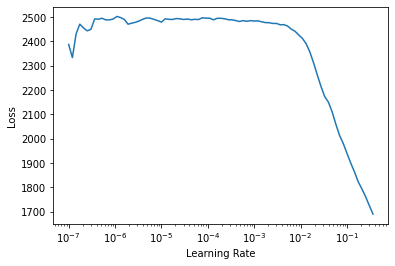

In [19]:
suggested_lrs = learn.lr_find()
suggested_lrs.lr_min

epoch,train_loss,valid_loss,time
0,2444.681396,2229.954102,00:00
1,2262.520996,1722.106689,00:00
2,1680.936523,165.106659,00:00
3,1224.368042,175.409485,00:00
4,916.648315,110.417038,00:00
5,712.018982,48.785042,00:00
6,566.470764,79.928383,00:00
7,456.248260,16.637503,00:00
8,371.093262,28.186945,00:00
9,307.227234,27.386921,00:00


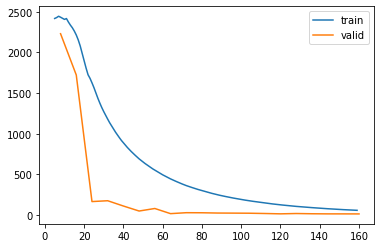

In [20]:
learn.fit_one_cycle(n_epoch=20, lr_max=suggested_lrs.lr_min)
learn.recorder.plot_loss()

In [0]:
nCases = 200
samplesANN = []

for ii in range(nCases):

  T_h0 = 280 + 20*np.random.randn() ;
  T_h20= 218 + 10*np.random.randn() ;
  T_h50= 270 + 20*np.random.randn() ;
  T_h70= 216 + 25*np.random.randn() ;
  T_h90= 185 + 25*np.random.randn() ;
  T_h120 = 360 + 25*np.random.randn() ;

  rho_h0 = 1.225 + 0.1*np.random.randn() ;
  rho_h40 = 4e-3 + 5e-4*np.random.randn() ;
  rho_h90 = 3.5e-6 + 6e-7*np.random.randn() ;
  rho_h120 = 2.5e-8 + 5e-9*np.random.randn() ; 

  parts_n2 = np.random.uniform()*(0.2) + 0.7 ;
  cp = np.random.uniform()*200 + 1300 ;
  gamma = np.random.uniform()*(-2) - 0.5 ;
  res = np.random.uniform()*100 + 7550 ;
  mod = np.random.uniform()*100 + 200 ;
  Xi = np.random.uniform()*10 + 33 ;

  samplesANN.append([T_h0, T_h20, T_h50, T_h70, T_h90, T_h120, rho_h0, rho_h40, rho_h90, rho_h120, parts_n2, cp, gamma, res, mod, Xi])

samplesANN = np.array(samplesANN)

In [0]:
samplesANN = pd.DataFrame(samplesANN, columns=['T_h0', 'T_h20', 'T_h50', 'T_h70', 'T_h90', 'T_h120', 'rho_h0',
             'rho_h40', 'rho_h90', 'rho_h120', 'parts_n2', 'cp', 'gamma', 'res',
             'mod', 'Xi'])

In [0]:
dl = learn.dls.test_dl(samplesANN)

In [24]:
raw_test_preds = learn.get_preds(dl=dl)
predArray = np.array(raw_test_preds[0])

In [26]:
statsML = ComputeStatParam(predArray.T[0])
statsML

[46.91507339477539    (46.11564178466797, 47.697355842590326),
 5.647927284240723    (5.157721018791199, 6.180571436882019),
 0.41150403253353357,
 2.671267329791721]

### SHAP

In [27]:
!pip install -q fastshap

     |████████████████████████████████| 276kB 11.1MB/s 


In [0]:
from fastshap.interp import *

In [29]:
learn.dl.vocab = learn.dl.y_names # This is only needed for regression problems
exp = ShapInterpretation(learn)

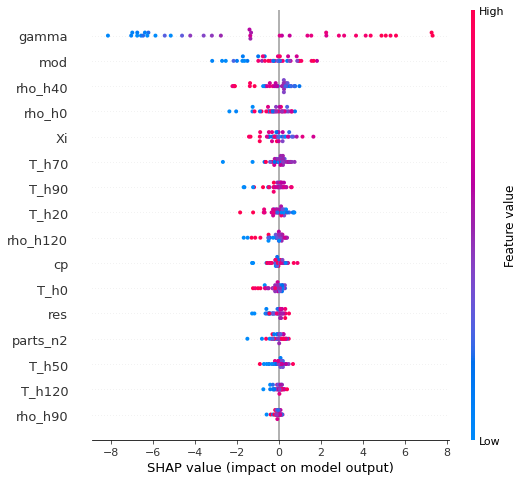

In [30]:
exp.summary_plot()

## KS Test

In [0]:
from scipy import stats

import numpy as np
import matplotlib.pyplot as plt

In [0]:
Nsamples1=len(np.array(samples["lat"]))
Nsamples2=len(predArray.T[0])

In [0]:
Nruns=1000
VV=[];
Calpha05=1.358
Calpha01=1.628
nrj05=0
nrj01=0

In [0]:
for i in range(Nruns):
	xs1 = np.array(samples["lat"])
	xs2 = predArray.T[0]
	KsStat,Ks_pvalue=stats.ks_2samp(xs1, xs2)

	DT05=Calpha05*np.sqrt((Nsamples1+Nsamples2)/Nsamples1/Nsamples2)
	if KsStat>DT05:
		rj05=1;
		nrj05=nrj05+1
	else:
		rj05=0;
	DT01=Calpha01*np.sqrt((Nsamples1+Nsamples2)/Nsamples1/Nsamples2)
	if KsStat>DT01:
		rj01=1;
		nrj01=nrj01+1
	else:
		rj01=0;
	VV.append([KsStat,Ks_pvalue, DT05, DT01, rj05, rj01])

The Null Hypothesis (distributions are equal) is rejected  1000  times over  1000  ( 100.0 %) with alpha=0.05
The Null Hypothesis (distributions are equal) is rejected  0  times over  1000  ( 0.0 %) with alpha=0.01


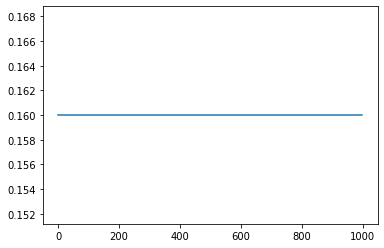

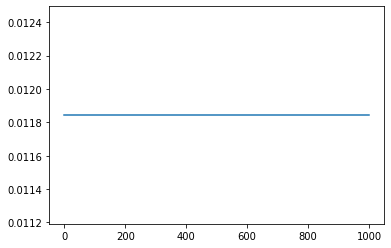

In [44]:
VV=np.array(VV)
sortedVV = VV[VV[:,1].argsort()]
np.savetxt('VVKS2s.dat', sortedVV, delimiter=' ')
plt.figure()
plt.plot(sortedVV[:,0])
plt.figure()
plt.plot(sortedVV[:,1])
print("The Null Hypothesis (distributions are equal) is rejected ",nrj05," times over ",Nruns," (",nrj05/Nruns*100,"%) with alpha=0.05")
print("The Null Hypothesis (distributions are equal) is rejected ",nrj01," times over ",Nruns," (",nrj01/Nruns*100,"%) with alpha=0.01")

## Histograms

In [36]:
import seaborn as sns

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


https://cmdlinetips.com/2019/02/how-to-make-histogram-in-python-with-pandas-and-seaborn/

Text(0, 0.5, 'Density')

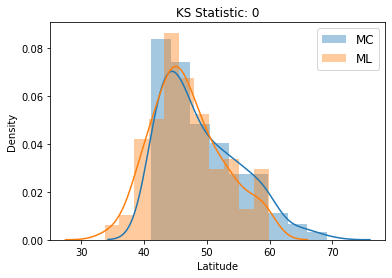

In [46]:
# 1d hist
# data['lon'].hist(bins=100)

#
sns.distplot(np.array(samples["lat"]), hist = True, kde = True, label='MC')
#
sns.distplot(predArray.T[0], hist = True, kde = True, label='ML')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('KS Statistic: {}'.format(0))
plt.xlabel('Latitude')
plt.ylabel('Density')  

In [0]:
# 2d hist
# sns.jointplot(x=preds_longitude, y=preds_latitude, kind="hex") 